In [1]:
pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub
import pandas as pd
import numpy as np
import pickle
import cv2
import os
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2025-09-26 18:02:27.127671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758909747.322128      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758909747.378525      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_path = kagglehub.dataset_download("valentynsichkar/traffic-signs-preprocessed")
print("Path to dataset files:", base_path)

Path to dataset files: /kaggle/input/traffic-signs-preprocessed


In [5]:
# Read classes
label_path = os.path.join(base_path, 'label_names.csv')
labels = pd.read_csv(label_path)
num_classes = len(labels)
print(f'Dataset Classes:\n\n{labels}')

Dataset Classes:

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                          

In [6]:
# Copy label file
dest_path = os.path.join(os.getcwd(), 'label_names.csv')
shutil.copy(label_path, dest_path)

'/kaggle/working/label_names.csv'

In [7]:
# Check the image array format
data_path = f"data0.pickle"
data_file = os.path.join(base_path, data_path)
    
with open(data_file, "rb") as f:
    data = pickle.load(f)
    
# Process and append the arrays to their respective lists
print(data['x_train'].shape)

(86989, 3, 32, 32)


* Image Preprocessing and Data Cleaning

In [8]:
def data_preprocessing(x_array, y_array, num_classes):
    """
    - Transpose images from (C, H, W) to (H, W, C)
    - Convert ALL images to single-channel Grayscale (H, W, 1)
    - No normalization (pixel range remains [0, 255])
    - One-hot encode labels
    """
    processed_images = []
    labels = []

    for img in x_array:
        # Convert to float32 early to handle calculations consistently
        img = img.astype(np.float32)

        # Grayscale image: C=1 -> Transpose to (H, W, 1)
        if img.shape[0] == 1:
            grayscale = np.transpose(img, (1, 2, 0))
            
        # Color image: C=3 -> Convert to Grayscale (H, W, 1)
        elif img.shape[0] == 3:
            # Transpose from (C, H, W) to (H, W, C)
            rgb_transposed = np.transpose(img, (1, 2, 0))
            
            # Convert to uint8 for cv2 (assuming input is [0, 255])
            rgb_for_cv2 = np.clip(rgb_transposed, 0, 255).astype(np.uint8)
            
            # Convert Color to Grayscale (H, W, 3) -> (H, W)
            gray_hw = cv2.cvtColor(rgb_for_cv2, cv2.COLOR_RGB2GRAY)
            
            # Add channel dimension: (H, W) -> (H, W, 1) and keep as float32
            grayscale = np.expand_dims(gray_hw.astype(np.float32), axis=-1)

        processed_images.append(grayscale)

    # One-hot encode labels
    labels_cat = to_categorical(y_array, num_classes=num_classes)
    
    # Return images as (N, H, W, 1) float32 array and one-hot labels
    return np.array(processed_images, dtype=np.float32), labels_cat

In [9]:
all_x_train, all_y_train = [], []
all_x_valid, all_y_valid = [], []
all_x_test,  all_y_test  = [], []

for data_no in range(9):
    data_file = os.path.join(base_path, f"data{data_no}.pickle")
    with open(data_file, "rb") as f:
        data = pickle.load(f)

    x_train_chunk, y_train_chunk = data_preprocessing(data['x_train'], data['y_train'], num_classes)
    x_valid_chunk, y_valid_chunk = data_preprocessing(data['x_validation'], data['y_validation'], num_classes)
    x_test_chunk,  y_test_chunk  = data_preprocessing(data['x_test'],  data['y_test'], num_classes)

    all_x_train.append(x_train_chunk)
    all_y_train.append(y_train_chunk)

    all_x_valid.append(x_valid_chunk)
    all_y_valid.append(y_valid_chunk)

    all_x_test.append(x_test_chunk)
    all_y_test.append(y_test_chunk)

In [10]:
# Concatenate all chunks
x_train = np.concatenate(all_x_train, axis=0)
y_train = np.concatenate(all_y_train, axis=0)

x_valid = np.concatenate(all_x_valid, axis=0)
y_valid = np.concatenate(all_y_valid, axis=0)

x_test = np.concatenate(all_x_test, axis=0)
y_test = np.concatenate(all_y_test, axis=0)

In [11]:
print("Final dataset shapes:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_valid: {x_valid.shape}, y_valid: {y_valid.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

Final dataset shapes:
x_train: (782901, 32, 32, 1), y_train: (782901, 43)
x_valid: (39690, 32, 32, 1), y_valid: (39690, 43)
x_test: (113670, 32, 32, 1), y_test: (113670, 43)


In [12]:
print(f"Minimum value of x_train dataset: {x_train.min()}")
print(f"Maximum value of x_train dataset: {x_train.max()}")

print(f"Minimum value of x_valid dataset: {x_valid.min()}")
print(f"Maximum value of x_valid dataset: {x_valid.max()}")

print(f"Minimum value of x_test dataset: {x_test.min()}")
print(f"Maximum value of x_test dataset: {x_test.max()}")

Minimum value of x_train dataset: -1.9063234329223633
Maximum value of x_train dataset: 255.0
Minimum value of x_valid dataset: -1.845461368560791
Maximum value of x_valid dataset: 255.0
Minimum value of x_test dataset: -1.8758924007415771
Maximum value of x_test dataset: 255.0


* Save the datasets

In [13]:
#!rm -rf /kaggle/working/*

In [14]:
with open('x_train.pkl', 'wb') as file: pickle.dump(x_train, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pkl', 'wb') as file: pickle.dump(y_train, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('x_valid.pkl', 'wb') as file: pickle.dump(x_valid, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_valid.pkl', 'wb') as file: pickle.dump(y_valid, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('x_test.pkl', 'wb') as file: pickle.dump(x_test, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pkl', 'wb') as file: pickle.dump(y_test, file, protocol=pickle.HIGHEST_PROTOCOL)

**Data Visualization**

* Class-wise Sample Distribution

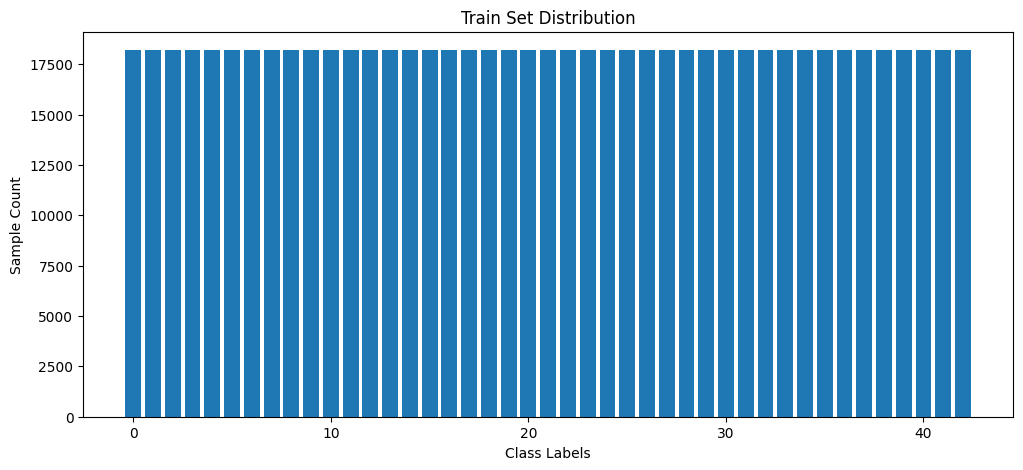

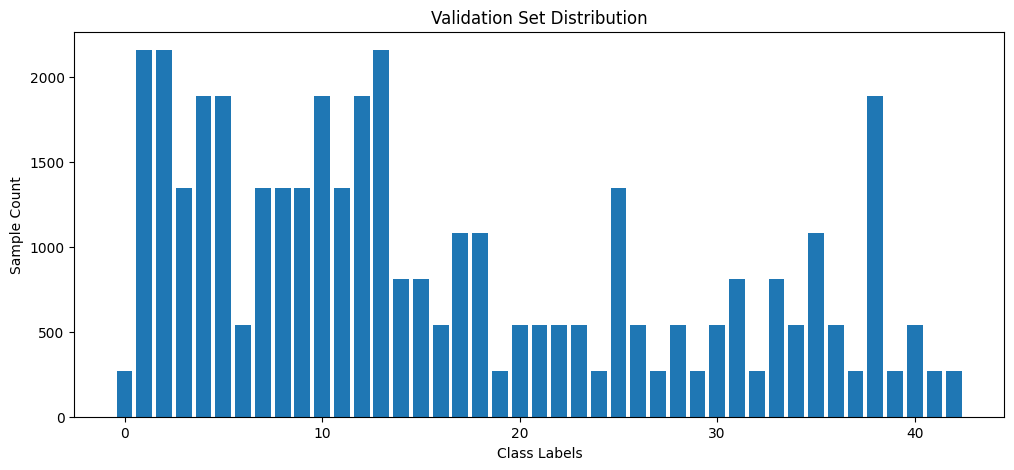

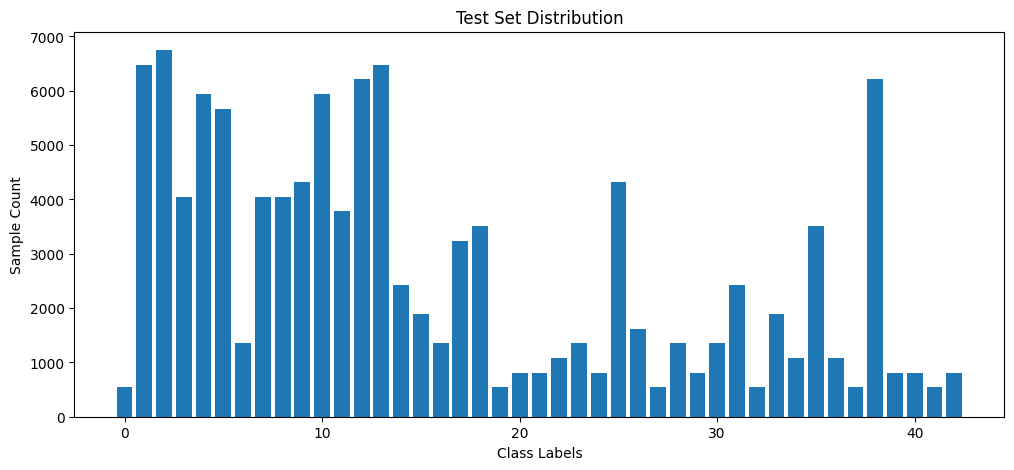

In [15]:
def plot_distribution(y, title):
    class_counts = np.sum(y, axis=0)
    plt.figure(figsize=(12,5))
    plt.bar(range(len(class_counts)), class_counts)
    plt.title(title)
    plt.xlabel("Class Labels")
    plt.ylabel("Sample Count")
    plt.show()

plot_distribution(y_train, "Train Set Distribution")
plot_distribution(y_valid, "Validation Set Distribution")
plot_distribution(y_test, "Test Set Distribution")

* Random Samples with Labels

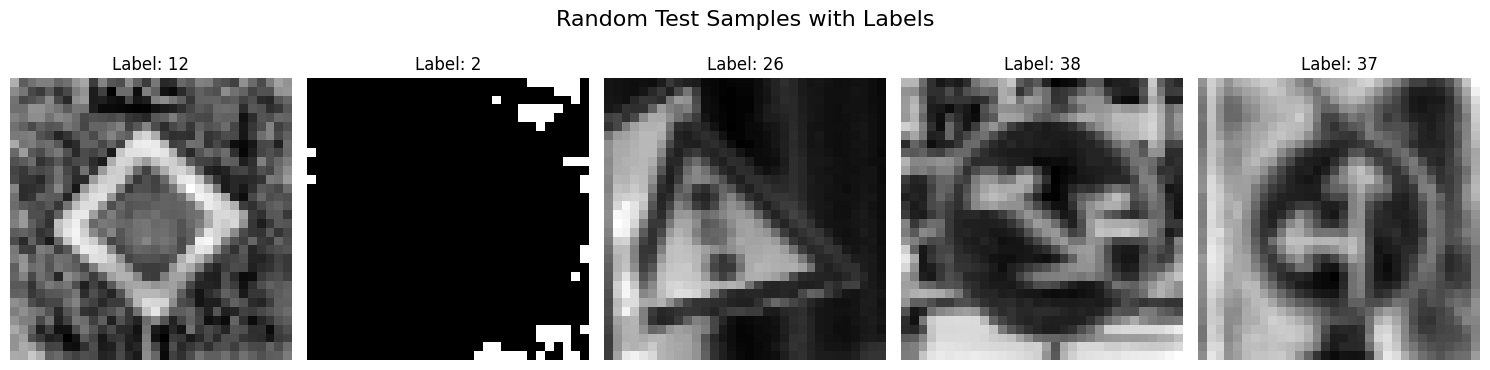

In [16]:
num_samples = 5
indices = np.random.choice(len(x_test), num_samples, replace=False)
fig, axs = plt.subplots(1, num_samples, figsize=(15, 4))
fig.suptitle('Random Test Samples with Labels', fontsize=16)

for i, ax in enumerate(axs.flatten()):
    img = x_test[indices[i]]
    label = np.argmax(y_test[indices[i]])
    ax.imshow(img, cmap='gray') 
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

* Detection of Mostly Black (Blank) Images within "data0.pickle" File

In [17]:
data_file = os.path.join(base_path, "data0.pickle")

# Open the pickle file in read-binary mode
with open(data_file, "rb") as f:
    # Load the data from the file
    data = pickle.load(f)

# Select the training images from the loaded data
images = data['x_train']

def find_mostly_black_images(images, threshold=10, black_ratio=0.95, max_show=10):
    mostly_black_idxs = []
    for idx, img in enumerate(images):
        # Transpose from (C, H, W) to (H, W, C) for display/calculation
        if img.shape[0] in [1, 3]:
            img_show = np.transpose(img, (1, 2, 0)).squeeze()
        else:
            img_show = img.squeeze()
            
        # Black pixel rate calculation
        # Count pixels below the brightness threshold
        black_pixels = np.sum(img_show < threshold)
        total_pixels = img_show.size
        ratio = black_pixels / total_pixels
        
        # Check if the ratio of black pixels exceeds the required threshold
        if ratio > black_ratio:
            mostly_black_idxs.append((idx, ratio))

    # Print the final count of mostly black images found
    print(f"Found {len(mostly_black_idxs)} mostly black images.")

find_mostly_black_images(images)

Found 270 mostly black images.
